In [ ]:
# Make a directory for Kaggle and copy the kaggle.json file there
!mkdir -p ~/.kaggle
!cp "/content/kaggle.json" ~/.kaggle/

# Change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

# Install the Kaggle API client
!pip install kaggle


cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Replace 'dataset-name/kaggle-dataset' with the appropriate dataset path on Kaggle
!kaggle datasets download -d msambare/fer2013 -p /content/


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 99% 60.0M/60.3M [00:02<00:00, 29.3MB/s]
100% 60.3M/60.3M [00:02<00:00, 22.0MB/s]


In [ ]:
!unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Define paths
train_dir = '/content/train'
test_dir = '/content/test'


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define paths
train_dir = '/content/train'
test_dir = '/content/test'

# Define ImageDataGenerator for training and testing with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create iterators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine the base model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10
)

# Unfreeze some of the base model layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=17
)

# Save the model
model.save('emotion_recognition_model_vgg16.h5')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
448/448 [==============================] - 440s 953ms/step - loss: 1.7259 - accuracy: 0.2973 - val_loss: 1.6609 - val_accuracy: 0.3320
Epoch 2/10
448/448 [==============================] - 407s 908ms/step - loss: 1.6520 - accuracy: 0.3439 - val_loss: 1.6276 - val_accuracy: 0.3584
Epoch 3/10
448/448 [==============================] - 425s 947ms/step - loss: 1.6206 - accuracy: 0.3620 - val_loss: 1.6918 - val_accuracy: 0.3112
Epoch 4/10
448/448 [==============================] - 423s 943ms/step - loss: 1.6048 - accuracy: 0.3701 - val_loss: 1.6623 - val_accuracy: 0.3313
Epoch 5/10
448/448 [==============================] - 407s 908ms/step - loss: 1.5946 - accuracy: 0.3753 - val_loss: 1.5739 - val_accuracy: 0.3820
Epoch 6/10
448/448 [==============================] - 424s 946ms/step - loss: 1.5808 - accuracy: 0.3828 - val_loss: 1.66

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 7178 images belonging to 7 classes.
113/113 [==============================] - 48s 277ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.55      0.55       958
     disgust       0.80      0.41      0.54       111
        fear       0.58      0.32      0.41      1024
       happy       0.81      0.88      0.84      1774
     neutral       0.56      0.64      0.60      1233
         sad       0.50      0.56      0.53      1247
    surprise       0.74      0.78      0.76       831

    accuracy                           0.64      7178
   macro avg       0.65      0.59      0.60      7178
weighted avg       0.64      0.64      0.63      7178



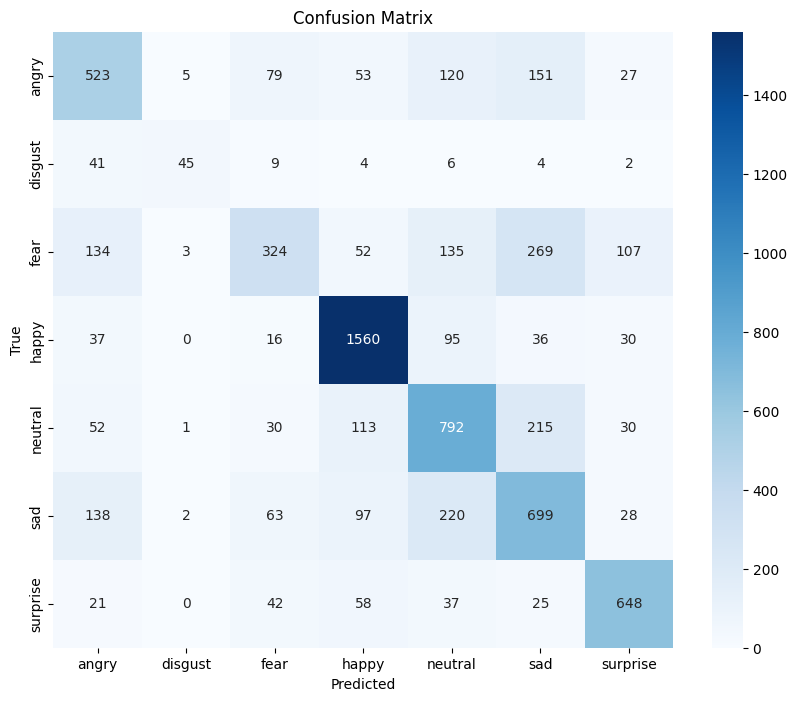

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/content/drive/MyDrive/emotion_recognition_model_vgg16.h5')

# Define the ImageDataGenerator for the test set (already done, include if running independently)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the test generator (already done, include if running independently)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Predict the labels for the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


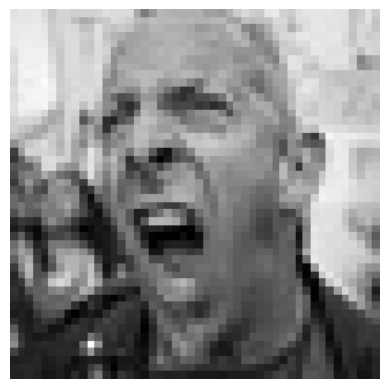

1/1 [==============================] - 1s 1s/step
The predicted label is: angry


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/emotion_recognition_model_vgg16.h5')

# Define class labels (same order as in your training set)
class_labels = list(test_generator.class_indices.keys())

# Function to preprocess the image and make a prediction
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Reshape and preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Path to the image you want to predict
img_path = '/content/test/angry/PrivateTest_12008383.jpg'

# Predict and print the result
predicted_label = predict_image(img_path)
print(f'The predicted label is: {predicted_label}')


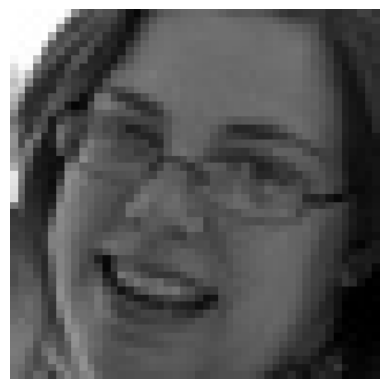

1/1 [==============================] - 0s 227ms/step
The predicted label is: happy


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/emotion_recognition_model_vgg16.h5')

# Define class labels (same order as in your training set)
class_labels = list(test_generator.class_indices.keys())

# Function to preprocess the image and make a prediction
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Reshape and preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Path to the image you want to predict
img_path = '/content/train/happy/Training_10019449.jpg'
# Predict and print the result
predicted_label = predict_image(img_path)
print(f'The predicted label is: {predicted_label}')


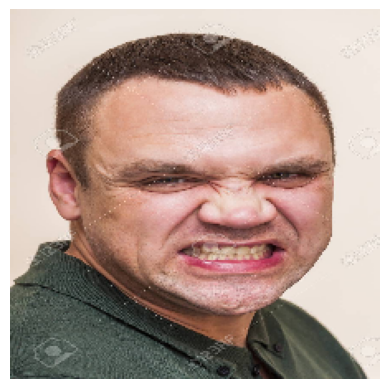

1/1 [==============================] - 0s 147ms/step
The predicted label is: angry


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/emotion_recognition_model_vgg16.h5')

# Define class labels (same order as in your training set)
class_labels = list(test_generator.class_indices.keys())

# Function to preprocess the image and make a prediction
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Reshape and preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Path to the image you want to predict
img_path = '/content/angry.jpg'
# Predict and print the result
predicted_label = predict_image(img_path)
print(f'The predicted label is: {predicted_label}')


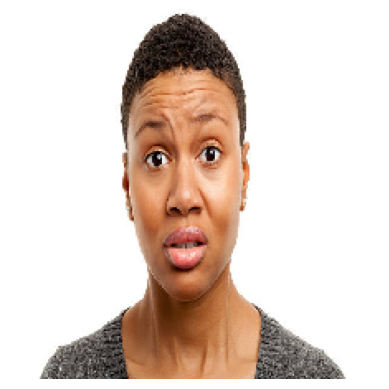

1/1 [==============================] - 0s 233ms/step
The predicted label is: fear


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/emotion_recognition_model_vgg16.h5')

# Define class labels (same order as in your training set)
class_labels = list(test_generator.class_indices.keys())

# Function to preprocess the image and make a prediction
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Reshape and preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Path to the image you want to predict
img_path = '/content/fear.jpg'
# Predict and print the result
predicted_label = predict_image(img_path)
print(f'The predicted label is: {predicted_label}')


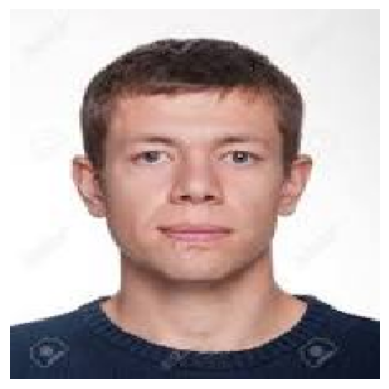

1/1 [==============================] - 0s 145ms/step
The predicted label is: neutral


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/emotion_recognition_model_vgg16.h5')

# Define class labels (same order as in your training set)
class_labels = list(test_generator.class_indices.keys())

# Function to preprocess the image and make a prediction
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Reshape and preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Path to the image you want to predict
img_path = '/content/nuetral.jpg'
# Predict and print the result
predicted_label = predict_image(img_path)
print(f'The predicted label is: {predicted_label}')


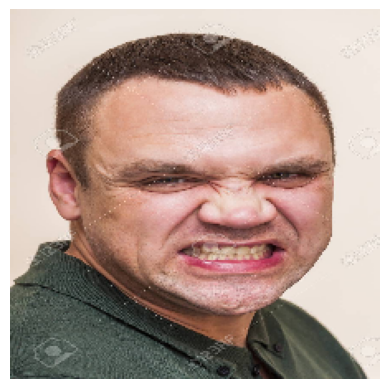

1/1 [==============================] - 1s 1s/step
The predicted label is: angry


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/emotion_recognition_model_vgg16.h5')

# Define class labels (same order as in your training set)
class_labels = list(test_generator.class_indices.keys())

# Function to preprocess the image and make a prediction
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Reshape and preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Path to the image you want to predict
img_path = '/content/angry.jpg'

# Predict and print the result
predicted_label = predict_image(img_path)
print(f'The predicted label is: {predicted_label}')
